In [1]:
import os  #finds our current directory path

In [2]:
#set some variables
STRUCTURE= ['RS','TSA']

Null perturbation

In [ ]:
# Make restraint file for null perturbation
# Writing d_com.rst files for md
for structure in STRUCTURE:

    filename = f"/user/work/zn22275/{structure}_null/{structure}_null"
    print (filename)

    #Make .in files    (write what each line means)
    d_com = f"""restraint to keep substrate in place
&rst
    iat=-1,-1,
    igr1=9124,9125,9126,9127,9128,9129,9130,9131,9132,9133,9134,9135,9136,9137,9138,9139,9140,9141,9142,9143,9144,9145,
    igr2=3189,5322,
    r1=0,r2=0,r3=10.0,r4=30.0,
    rk2=0,rk3=15,
/
"""
    with open(f"{filename}_d_com.rst", "w") as f:
        f.writelines(d_com)


/user/work/zn22275/RS_null/RS_null
/user/work/zn22275/TSA_null/TSA_null


In [ ]:
# 5ns MD with restraints
# writing AMBER .in files for md

for structure in STRUCTURE:

    filename = f"/user/work/zn22275/{structure}_null/{structure}_null"
    print (filename)

    #Make .in files    (write what each line means)
    md5 = f"""5ns NVT MD production (weak coupling of 10 ps)
&cntrl 
    imin                = 0,       
    irest               = 0,      !so doesn't take velocity but assign new ones from random 
    ntx                 = 1,      !read coordinates but not velocity  
    iwrap               = 1,       
    nstlim              = 2500000, 
    dt                  = 0.002,   
    ntpr                = 500, 
    ntwx                = 500, 
    ioutfm              = 1, 
    ntwr                = 50000,
    ntc                 = 2, 
    ntf                 = 2, 
    cut                 = 8.0,
    ntb                 = 1, 
    ntp                 = 0,
    ntt                 = 1, 
    tautp               = 10.0, 
    temp0               = 300.0,      !temperature which we will be changing
    nmropt              = 1,
/
&wt type='DUMPFREQ', istep1=500 /
&wt type='END' / 
DISANG=/user/work/zn22275/{structure}_null/{structure}_null_d_com.rst
DUMPAVE=/user/work/zn22275/{structure}_null/{structure}_null_d_com.tra     
/ 
"""    
    with open(f"{filename}_md5.in", "w") as f:
        f.writelines(md5)

/user/work/zn22275/RS_null/RS_null
/user/work/zn22275/TSA_null/TSA_null


In [ ]:
# Run null perturabtion MD
def runjob_MD_null(structure,index):
    print(f"submitted null_MD_{index}_{structure}")
    temp = f"""#!/bin/bash
#SBATCH --account=CHEM021482
#SBATCH --gres=gpu:1
#SBATCH --partition gpu
#SBATCH --job-name=null_MD_{index}_{structure}
#SBATCH --output   null_MD_{index}_{structure}
#SBATCH --time=3-00:00:00  
#SBATCH --mem=12G

# 1. Load module(s)
module load apps/amber/24.tools.24

# 2. Set directories
cd {os.getcwd()}

# input_folder=/user/work/rt22543/dnmd/RS_run_mdrun    #rst7 with ligand in
# output_filepath=/user/work/rt22543/dnmd/null_mdrun  #name of output
# input_filepath=/user/work/rt22543/dnmd/md5.in        #md file name
# topology_file=/user/work/rt22543/dnmd/striped_MalL_RS.prmtop    #topology file- wet with ligand inside

# 3. Run MD job(s)  (5ns in steps of 5ns) then strip water from output

for x in $(seq 100 20 500)
do
    #autoimage .rst7 file to avoid problems
    cat > image.in <<EOF
parm /bp1/mulholland/zn22275/300K_MalL_{structure}/MalL_{structure}.prmtop
trajin /bp1/mulholland/zn22275/300K_MalL_{structure}/run_{index}/run_md${{x}}.rst7
autoimage
trajout /bp1/mulholland/zn22275/300K_MalL_{structure}/run_{index}/run_md${{x}}.rst7 ncrestart
go
EOF
    cpptraj < image.in &> image.out       
    #run md jobs
    pmemd.cuda  -O -i /user/work/zn22275/{structure}_null/{structure}_null_md5.in -o /user/work/zn22275/{structure}_null/run_{index}/null_md_${{x}}.log -p /bp1/mulholland/zn22275/300K_MalL_{structure}/MalL_{structure}.prmtop -c /bp1/mulholland/zn22275/300K_MalL_{structure}/run_{index}/run_md${{x}}.rst7 -x /user/work/zn22275/{structure}_null/run_{index}/null_md_${{x}}.nc -r /user/work/zn22275/{structure}_null/run_{index}/null_md_${{x}}.rst7

    cat > strip.in <<EOF
parm /bp1/mulholland/zn22275/300K_MalL_{structure}/output/MalL_{structure}.prmtop
trajin /user/work/zn22275/{structure}_null/run_{index}/null_md_${{x}}.nc
autoimage
strip @Na+
strip @Cl-
strip :WAT outprefix dry
outtraj /user/work/zn22275/{structure}_null/run_{index}/dry_null_md${{x}}.nc netcdf nobox
go
EOF
    cpptraj < strip.in &> strip.out

    #remove old nc after striping
    rm /user/work/zn22275/{structure}_null/run_{index}/null_md_${{x}}.nc
done
/       
"""
    
    with open(f"MD_null.sh", "w") as f:
        f.writelines(temp)

    !sbatch --exclude=bp1-gpu[007,035,030,024] MD_null.sh

In [6]:
for structure in STRUCTURE:       
    for index in range(1,11,1):
        runjob_MD_null(structure=structure,
            index=str(index))

submitted null_MD_1_RS
Submitted batch job 11725843
submitted null_MD_2_RS
Submitted batch job 11725844
submitted null_MD_3_RS
Submitted batch job 11725846
submitted null_MD_4_RS
Submitted batch job 11725848
submitted null_MD_5_RS
Submitted batch job 11725849
submitted null_MD_6_RS
Submitted batch job 11725850
submitted null_MD_7_RS
Submitted batch job 11725852
submitted null_MD_8_RS
Submitted batch job 11725853
submitted null_MD_9_RS
Submitted batch job 11725855
submitted null_MD_10_RS
Submitted batch job 11725856
submitted null_MD_1_TSA
Submitted batch job 11725857
submitted null_MD_2_TSA
Submitted batch job 11725858
submitted null_MD_3_TSA
Submitted batch job 11725860
submitted null_MD_4_TSA
Submitted batch job 11725861
submitted null_MD_5_TSA
Submitted batch job 11725863
submitted null_MD_6_TSA
Submitted batch job 11725864
submitted null_MD_7_TSA
Submitted batch job 11725865
submitted null_MD_8_TSA
Submitted batch job 11725866
submitted null_MD_9_TSA
Submitted batch job 11725867
su

In [16]:
# make null pdb
null_pdb = f"""#!/bin/bash
#SBATCH --account=CHEM021482
#SBATCH --partition test  ##Using test partition b/c v. slow queue for compute  
#SBATCH --job-name=make_nill_pdb
#SBATCH --output   make_null_pdb
#SBATCH --time=1:00:00       # Walltime 1 hour max on this partition
#SBATCH --nodes=1            # number of tasks was 12 
#SBATCH --ntasks-per-node=1 # number of tasks per node
#SBATCH --cpus-per-task=1
#SBATCH --mem=10G

module load apps/amber/24.tools.24

cd {os.getcwd()}

source /user/work/zn22275/anaconda3/etc/profile.d/conda.sh

conda activate /user/work/zn22275/anaconda3/envs/dnemd

python null_pdb.py

"""

with open(f"null_pdb.sh","w") as f:
    f.writelines(null_pdb)

In [17]:
!sbatch null_pdb.sh

Submitted batch job 11759709


In [ ]:
# 0 null MD pdb
def initial_pdb(structure,index,rep):
    initial_pdb = f"""
    parm /bp1/mulholland/zn22275/300K_MalL_{structure}/MalL_{structure}.prmtop
    trajin /bp1/mulholland/zn22275/300K_MalL_{structure}/run_{index}/run_md{rep}.rst7
    autoimage
    strip @Na+
    strip @Cl-
    strip :WAT outprefix dry
    outtraj /user/work/zn22275/{structure}_null_pdb/run_{index}/null_md{rep}_0.pdb
    go  
"""    
    with open('initial_pdb.in', "w") as f: 
        f.writelines(initial_pdb)  #write the file

    !cpptraj -i initial_pdb.in  #use cpptraj

list = [100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480]
#apply function
for structure in STRUCTURE:
    for num in range(1,11,1):
        for rep in list:
            initial_pdb(structure=structure,
                        index=num,
                        rep = rep)


CPPTRAJ: Trajectory Analysis. V6.18.1 (AmberTools)
    ___  ___  ___  ___
     | \/ | \/ | \/ | 
    _|_/\_|_/\_|_/\_|_

| Date/time: 03/14/25 11:22:26
| Available memory: 208.780 GB

INPUT: Reading input from 'initial_pdb.in'
  [parm /bp1/mulholland/zn22275/300K_MalL_RS/MalL_RS.prmtop]
	Reading '/bp1/mulholland/zn22275/300K_MalL_RS/MalL_RS.prmtop' as Amber Topology
	Radius Set: modified Bondi radii (mbondi)
  [trajin /bp1/mulholland/zn22275/300K_MalL_RS/run_1/run_md100.rst7]
	Reading '/bp1/mulholland/zn22275/300K_MalL_RS/run_1/run_md100.rst7' as Amber NC Restart
  [autoimage]
    AUTOIMAGE: To box center based on center of mass, anchor is first molecule.
  [strip @Na+]
    STRIP: Stripping atoms in mask [@Na+]
  [strip @Cl-]
    STRIP: Stripping atoms in mask [@Cl-]
  [strip :WAT outprefix dry]
    STRIP: Stripping atoms in mask [:WAT]
	Writing 'stripped' topology file with prefix 'dry'
  [outtraj /user/work/zn22275/RS_null_pdb/run_1/null_md100_0.pdb]
	Writing '/user/work/zn22275/RS_

Displacement of null from equilibrium

In [ ]:
# 2 sig Eq-Null
import MDAnalysis as mda
from MDAnalysis.analysis import align
import numpy as np
import matplotlib.pyplot as plt

STRUCTURE= ['RS','TSA']
runs = [1,2,3,4,5,6,7,8,9,10] 
times = [i for i in range(100, 500, 20)]


for structure in STRUCTURE:
# Load the base reference C-alpha structure
    base_ref = mda.Universe(f'/user/work/zn22275/{structure}_dry_pdb/run_1/dry_md100_0.pdb')
    base_ca = base_ref.select_atoms('name CA')

# Create a new Universe object with only the C-alpha atoms
    ca_universe = mda.Merge(base_ca)

# Save the positions of base C-alpha atoms to a file
    np.savetxt("base_ca.txt", base_ca.positions)


    time_points =  [0, 2, 5, 7, 10, 12, 25, 50, 125, 150, 200, 250, 500, 750, 1000, 1250, 2500]


    for tp in time_points:
        vectors = []
        for run in runs:
            for time in times:
                try:
                    ref = mda.Universe(f'/user/work/zn22275/{structure}_dry_pdb/run_{run}/dry_md{time}_{tp}.pdb')
                    other = mda.Universe(f'/user/work/zn22275/{structure}_null_pdb/run_{run}/null_md{time}_{tp}.pdb')
                    mda.analysis.align.alignto(other, ref, select='name CA')
                    ca_ref = ref.select_atoms('name CA').positions
                    ca_other = other.select_atoms('name CA').positions
                    diff = ca_other - ca_ref
                    vectors.append(diff)
                except Exception as e:
                    print(f"Error processing {run}/{time}: {e}")
                    continue

        avg_vectors = np.mean(np.array(vectors), axis=0)

        # Calculate stats
        avg_disp = np.linalg.norm(avg_vectors, axis=1)
        sd = np.std(vectors, axis=0)
        se = sd / np.sqrt(len(vectors))
        avg_x = avg_vectors[:, 0]
        avg_y = avg_vectors[:, 1]
        avg_z = avg_vectors[:, 2]

        # SE of magnitude
        se_mag = (1 / avg_disp) * np.sqrt((avg_x**2)*(se[:, 0]**2) + (avg_y**2)*(se[:, 1]**2) + (avg_z**2)*(se[:, 2]**2))

        adjusted_avg_disp = np.where(np.abs(avg_disp) - 2*se_mag > 0, avg_disp, 0)
        adjusted_avg_vectors = np.where(np.abs(avg_vectors) - 2*se > 0, avg_vectors, 0)

        # # Write summary stats
        #     with open(f"vec_norm_stats_{tp}.txt", 'w') as f:
        #         for i in range(len(avg_vectors)):
        #             f.write(f"{adjusted_avg_vectors[i][0]}\t{adjusted_avg_vectors[i][1]}\t{adjusted_avg_vectors[i][2]}\t{adjusted_avg_disp[i]}\t{se[i][0]}\t{se[i][1]}\t{se[i][2]}\t{se_mag[i]}\n")

        # Write summary stats
        with open(f"/user/work/zn22275/null_vec_{structure}/stats/{structure}_null_vec_norm_stats_2sig_{tp}.txt", 'w') as f: # change file name
           # Write header
            f.write("#" * 128 + "\n")
            f.write("#                 Average Displacement                Sample Size                                   SE (1SD)                SE (1SD) of              SE (2SD)                SE (2SD) of       #\n")
            f.write("#              --------------------------       ---------------------      Average        --------------------------          Average        --------------------------          Average       #\n")
            f.write("#       CA     x-axis    y-axis    z-axis       x         y         z    Displacement     x-axis    y-axis    z-axis    Displacement vector  x-axis    y-axis    z-axis    Displacement vector #\n")
            f.write("#" * 128 + "\n")

            # Write data
            for i in range(len(avg_vectors)):
                f.write(f"{i+1:>9} {avg_vectors[i][0]:>8.3f} {avg_vectors[i][1]:>8.3f} {avg_vectors[i][2]:>8.3f} ") # removed adjusted vectors
                f.write(f"{len(vectors):>8} {len(vectors):>8} {len(vectors):>8} {avg_disp[i]:>12.3f} ") #removed adjusted displacement
                f.write(f"{se[i][0]:>10.3f} {se[i][1]:>10.3f} {se[i][2]:>10.3f} {se_mag[i]:>12.3f} ")
                f.write(f"{2*se[i][0]:>10.3f} {2*se[i][1]:>10.3f} {2*se[i][2]:>10.3f} {2*se_mag[i]:>12.3f}\n")


        # # Map the norms of the C-alpha vectors onto the C-alpha atoms in the new Universe object
        # for atom, bfactor in zip(ca_universe.atoms, adjusted_avg_disp):
        #     #atom.tempfactors = bfactor
        #     #print(bfactor)
        #     # with open(f"/user/work/zn22275/{structure}_vec/{structure}_vec_norm_{tp}.txt", 'w') as file:
        #     #     file.write(bfactor)

        # # ca_universe.atoms.tempfactors = adjusted_avg_disp
    
        # # Write the C-alpha-only structure with mapped B-factors
        # pdb_filename = f'/user/work/zn22275/{structure}_vec/{structure}_vec_norm_{tp}.pdb'
        # ca_universe.atoms.write(pdb_filename)

        with mda.Writer("temp_ca.pdb", ca_universe.atoms.n_atoms) as w: 
            w.write(ca_universe)
   
        # Now read it back and set the B-factors
        new_universe = mda.Universe("temp_ca.pdb")
        new_universe.add_TopologyAttr('tempfactors')  # Add the B-factor attribute explicitly
        new_universe.atoms.tempfactors = adjusted_avg_disp
   
        # Write the final PDB with B-factors
        pdb_filename = f'/user/work/zn22275/null_vec_{structure}/{structure}_null_vec_norm_2sig_{tp}.pdb'
        with mda.Writer(pdb_filename) as w:
            w.write(new_universe)


/user/work/zn22275/anaconda3/envs/dnemd/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/user/work/zn22275/anaconda3/envs/dnemd/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/user/work/zn22275/anaconda3/envs/dnemd/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarn

Subtraction of null pertubation from D-NEMD simulations - incorrect method

In [ ]:
# To do the subtraction of the b-factors in norm space(which is the displacement) - incorrect method

def subtract_b_factors(stripped_dir, null_dir, output_dir, file_range):
    
    for i in file_range:  #get directores (edit if cause troubles and write full file paths with space for i which )
        stripped_pdb = os.path.join(stripped_dir, f"{structure}_vec_norm_{i}.pdb") 
        null_pdb = os.path.join(null_dir, f"{structure}_null_vec_norm_{i}.pdb") 
        output_pdb = os.path.join(output_dir, f"{i}_modified.pdb") # name of output

        
        with open(stripped_pdb, 'r') as f1, open(null_pdb, 'r') as f2, open(output_pdb, 'w') as fout:  #opening each file
            stripped_lines = f1.readlines()
            null_lines = f2.readlines()
            
            for line1, line2 in zip(stripped_lines, null_lines):
                if line1.startswith("ATOM") or line1.startswith("HETATM"):
                    b_factor1 = float(line1[60:66])  # Extract B-factor from stripped
                    b_factor2 = float(line2[60:66])  # Extract B-factor from null
                    # new_b_factor = max(0.00, b_factor1 - b_factor2)  # Ensure no negative values, if negative changes it to 0.0
                    new_b_factor = abs(b_factor1 - b_factor2)  # Ensure absolute difference
                    # new_b_factor = b_factor1 - b_factor2  # Allow negative values
                    
                    new_line = line1[:60] + f"{new_b_factor:6.2f}" + line1[66:] #take coordinates from stripped pdb and put in new b-factors
                    fout.write(new_line)
                else:
                    fout.write(line1)  # Write non-ATOM/HETATM lines unchanged
        
        print(f"Processed {i}.pdb -> {output_pdb}")

ps_time_steps=[0, 2, 5, 7, 10, 12, 25, 50, 125, 150, 200, 250, 500, 750, 1000, 1250, 2500] # pdb timepoints

#This would do it for one structure at a time
#could rewrite to do loop an do both structure at a time
for structure in STRUCTURE:
    subtract_b_factors(f"/user/work/zn22275/{structure}_vec_2", f"/user/work/zn22275/{structure}_null_vec", f"/user/work/zn22275/modified_{structure}", ps_time_steps)


Processed 0.pdb -> /user/work/zn22275/modified_RS/0_modified.pdb
Processed 2.pdb -> /user/work/zn22275/modified_RS/2_modified.pdb
Processed 5.pdb -> /user/work/zn22275/modified_RS/5_modified.pdb
Processed 7.pdb -> /user/work/zn22275/modified_RS/7_modified.pdb
Processed 10.pdb -> /user/work/zn22275/modified_RS/10_modified.pdb
Processed 12.pdb -> /user/work/zn22275/modified_RS/12_modified.pdb
Processed 25.pdb -> /user/work/zn22275/modified_RS/25_modified.pdb
Processed 50.pdb -> /user/work/zn22275/modified_RS/50_modified.pdb
Processed 125.pdb -> /user/work/zn22275/modified_RS/125_modified.pdb
Processed 150.pdb -> /user/work/zn22275/modified_RS/150_modified.pdb
Processed 200.pdb -> /user/work/zn22275/modified_RS/200_modified.pdb
Processed 250.pdb -> /user/work/zn22275/modified_RS/250_modified.pdb
Processed 500.pdb -> /user/work/zn22275/modified_RS/500_modified.pdb
Processed 750.pdb -> /user/work/zn22275/modified_RS/750_modified.pdb
Processed 1000.pdb -> /user/work/zn22275/modified_RS/1000_

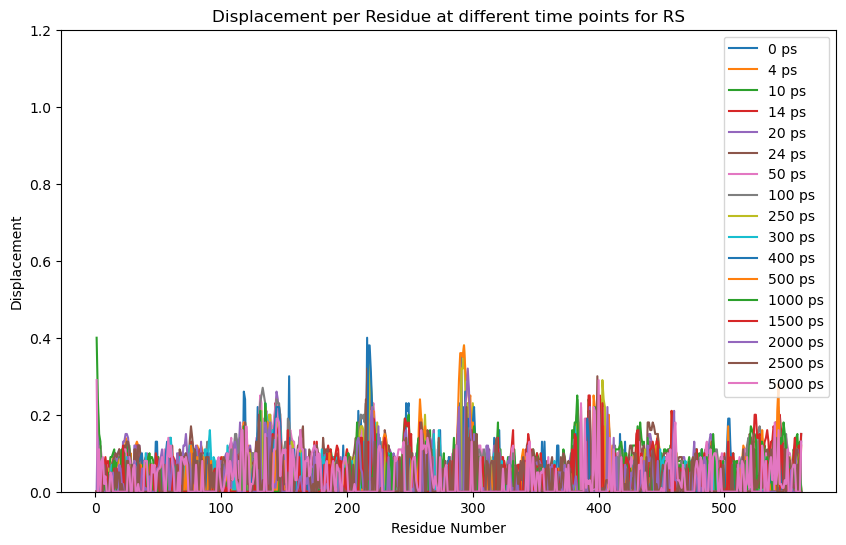

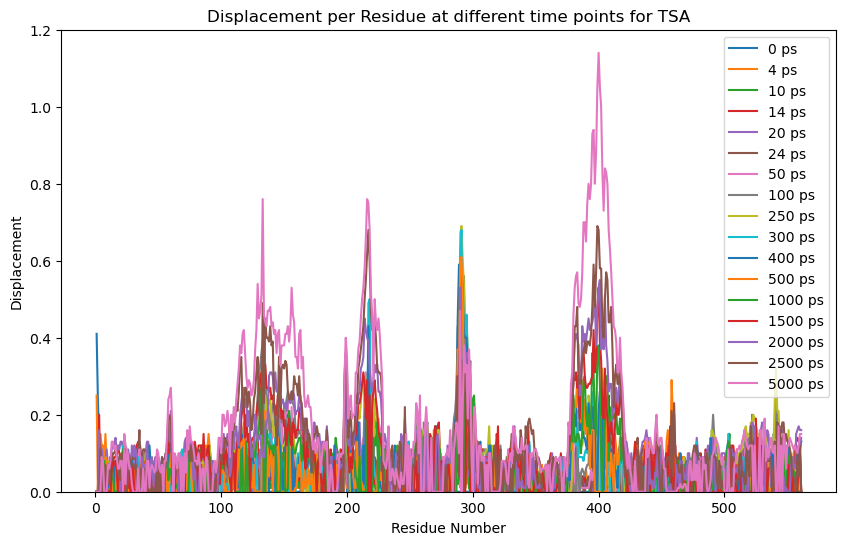

In [ ]:
import matplotlib.pyplot as plt

def plot_b_factors(output_dir, file_range):
    plt.figure(figsize=(10, 6))
    
    for i in file_range:
        output_pdb = os.path.join(output_dir, f"{i}_modified.pdb") #get file paths

        residues = []
        b_factors = []
        
        with open(output_pdb, 'r') as f:
            for line in f:
                if line.startswith("ATOM") or line.startswith("HETATM"):
                    res_num = int(line[22:26])  # Extract residue number
                    b_factor = float(line[60:66])  # Extract B-factor
                    residues.append(res_num)
                    b_factors.append(b_factor)
        time_point= i*2   #frame number time 2 as we save every 2 ps
        plt.plot(residues, b_factors, label=f"{time_point} ps")
    
    plt.xlabel("Residue Number")
    plt.ylabel("Displacement")
    plt.ylim(0, 1.2)
    plt.title(f"Displacement per Residue at different time points for {structure}")
    plt.legend()
    plt.show()

ps_time_steps=[0, 2, 5, 7, 10, 12, 25, 50, 125, 150, 200, 250, 500, 750, 1000, 1250, 2500]

for structure in STRUCTURE:
    plot_b_factors(f"/user/work/zn22275/modified_{structure}", ps_time_steps)

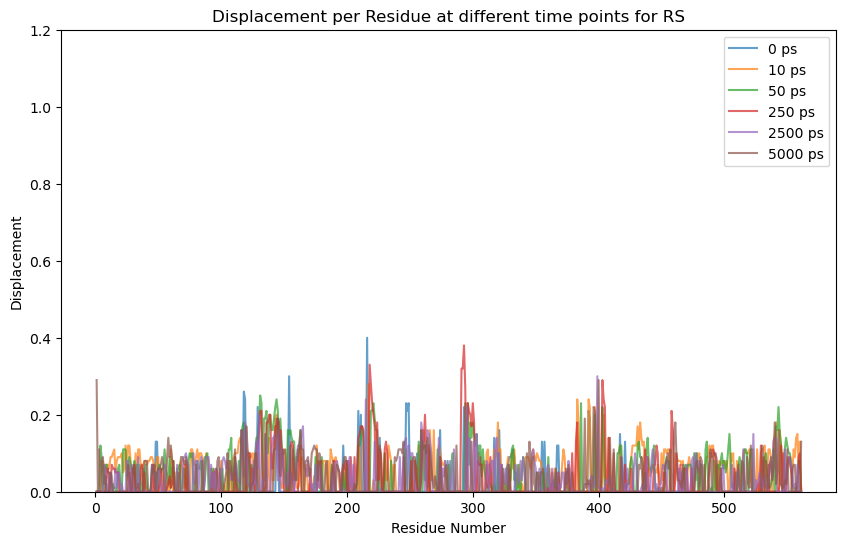

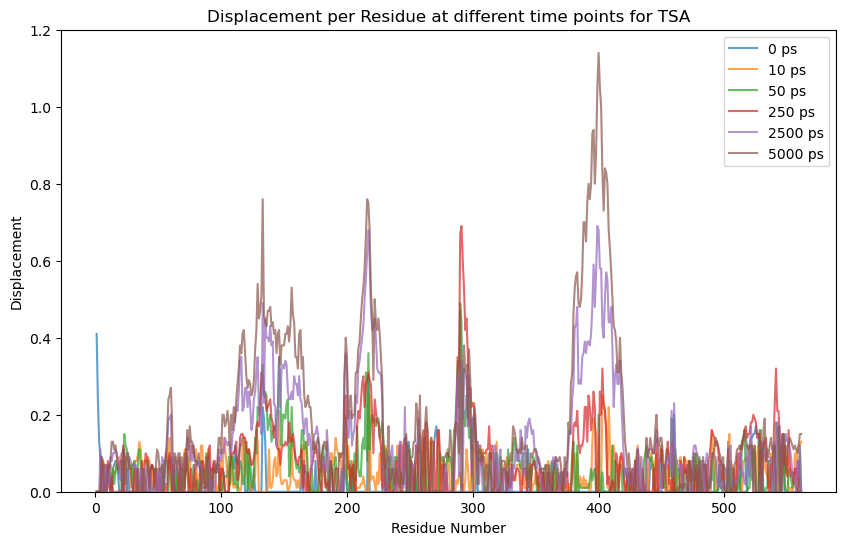

In [ ]:
import matplotlib.pyplot as plt

def plot_b_factors(output_dir, file_range):
    plt.figure(figsize=(10, 6))
    
    for i in file_range:
        output_pdb = os.path.join(output_dir, f"{i}_modified.pdb") #get file paths

        residues = []
        b_factors = []
        
        with open(output_pdb, 'r') as f:
            for line in f:
                if line.startswith("ATOM") or line.startswith("HETATM"):
                    res_num = int(line[22:26])  # Extract residue number
                    b_factor = float(line[60:66])  # Extract B-factor
                    residues.append(res_num)
                    b_factors.append(b_factor)
        time_point= i*2   #frame number time 2 as we save every 2 ps
        plt.plot(residues, b_factors, label=f"{time_point} ps", alpha=0.7)
    
    plt.xlabel("Residue Number")
    plt.ylabel("Displacement")
    plt.ylim(0, 1.2)
    plt.title(f"Displacement per Residue at different time points for {structure}")
    plt.legend()
    plt.show()

ps_time_steps=[0, 5, 25, 125, 1250, 2500]

for structure in STRUCTURE:
    plot_b_factors(f"/user/work/zn22275/modified_{structure}", ps_time_steps)

In [ ]:
# To do the subtraction of the b-factors (which is the displacement)- incorrect method

def subtract_b_factors(stripped_dir, null_dir, output_dir, file_range):
    
    for i in file_range:  #get directores (edit if cause troubles and write full file paths with space for i which )
        stripped_pdb = os.path.join(stripped_dir, f"{structure}_vec_norm_{i}.pdb") 
        null_pdb = os.path.join(null_dir, f"{structure}_null_vec_norm_{i}.pdb") 
        output_pdb = os.path.join(output_dir, f"{i}_modified_neg.pdb") # name of output

        
        with open(stripped_pdb, 'r') as f1, open(null_pdb, 'r') as f2, open(output_pdb, 'w') as fout:  #opening each file
            stripped_lines = f1.readlines()
            null_lines = f2.readlines()
            
            for line1, line2 in zip(stripped_lines, null_lines):
                if line1.startswith("ATOM") or line1.startswith("HETATM"):
                    b_factor1 = float(line1[60:66])  # Extract B-factor from stripped
                    b_factor2 = float(line2[60:66])  # Extract B-factor from null
                    # new_b_factor = max(0.00, b_factor1 - b_factor2)  # Ensure no negative values, if negative changes it to 0.0
                    # new_b_factor = abs(b_factor1 - b_factor2)  # Ensure absolute difference
                    new_b_factor = b_factor1 - b_factor2  # Allow negative values
                    
                    new_line = line1[:60] + f"{new_b_factor:6.2f}" + line1[66:] #take coordinates from stripped pdb and put in new b-factors
                    fout.write(new_line)
                else:
                    fout.write(line1)  # Write non-ATOM/HETATM lines unchanged
        
        print(f"Processed {i}.pdb -> {output_pdb}")

ps_time_steps=[0, 2, 5, 7, 10, 12, 25, 50, 125, 150, 200, 250, 500, 750, 1000, 1250, 2500] # pdb timepoints

#This would do it for one structure at a time
#could rewrite to do loop an do both structure at a time
for structure in STRUCTURE:
    subtract_b_factors(f"/user/work/zn22275/{structure}_vec_2", f"/user/work/zn22275/{structure}_null_vec", f"/user/work/zn22275/modified_{structure}", ps_time_steps)


Processed 0.pdb -> /user/work/zn22275/modified_RS/0_modified_neg.pdb
Processed 2.pdb -> /user/work/zn22275/modified_RS/2_modified_neg.pdb
Processed 5.pdb -> /user/work/zn22275/modified_RS/5_modified_neg.pdb
Processed 7.pdb -> /user/work/zn22275/modified_RS/7_modified_neg.pdb
Processed 10.pdb -> /user/work/zn22275/modified_RS/10_modified_neg.pdb
Processed 12.pdb -> /user/work/zn22275/modified_RS/12_modified_neg.pdb
Processed 25.pdb -> /user/work/zn22275/modified_RS/25_modified_neg.pdb
Processed 50.pdb -> /user/work/zn22275/modified_RS/50_modified_neg.pdb
Processed 125.pdb -> /user/work/zn22275/modified_RS/125_modified_neg.pdb
Processed 150.pdb -> /user/work/zn22275/modified_RS/150_modified_neg.pdb
Processed 200.pdb -> /user/work/zn22275/modified_RS/200_modified_neg.pdb
Processed 250.pdb -> /user/work/zn22275/modified_RS/250_modified_neg.pdb
Processed 500.pdb -> /user/work/zn22275/modified_RS/500_modified_neg.pdb
Processed 750.pdb -> /user/work/zn22275/modified_RS/750_modified_neg.pdb
Pr

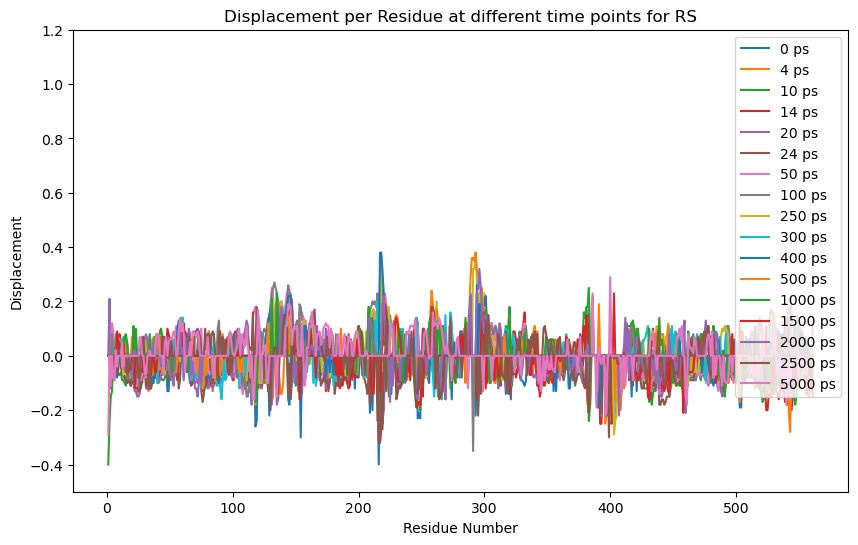

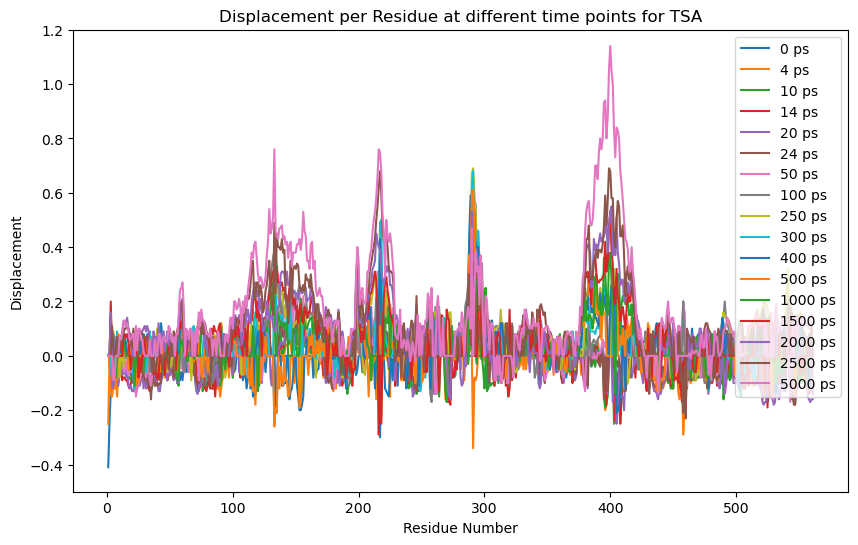

In [ ]:
#incorrect method
import matplotlib.pyplot as plt

def plot_b_factors(output_dir, file_range):
    plt.figure(figsize=(10, 6))
    
    for i in file_range:
        output_pdb = os.path.join(output_dir, f"{i}_modified_neg.pdb") #get file paths

        residues = []
        b_factors = []
        
        with open(output_pdb, 'r') as f:
            for line in f:
                if line.startswith("ATOM") or line.startswith("HETATM"):
                    res_num = int(line[22:26])  # Extract residue number
                    b_factor = float(line[60:66])  # Extract B-factor
                    residues.append(res_num)
                    b_factors.append(b_factor)
        time_point= i*2   #frame number time 2 as we save every 2 ps
        plt.plot(residues, b_factors, label=f"{time_point} ps")
    
    plt.xlabel("Residue Number")
    plt.ylabel("Displacement")
    plt.ylim(-0.5, 1.2)
    plt.title(f"Displacement per Residue at different time points for {structure}")
    plt.legend()
    plt.show()

ps_time_steps=[0, 2, 5, 7, 10, 12, 25, 50, 125, 150, 200, 250, 500, 750, 1000, 1250, 2500]

for structure in STRUCTURE:
    plot_b_factors(f"/user/work/zn22275/modified_{structure}", ps_time_steps)

Subtraction of null perturbation from D-NEMD simulations - Correct method

In [ ]:
# subtracting in vector space 2 sig
import MDAnalysis as mda
from MDAnalysis.analysis import align
import numpy as np
import matplotlib.pyplot as plt

STRUCTURE= ['RS','TSA']
runs = [i for i in range(1,11,1)]
times = [i for i in range(100, 500, 20)]

for structure in STRUCTURE:
# Load the base reference C-alpha structure
    base_ref = mda.Universe(f'/user/work/zn22275/{structure}_dry_pdb/run_1/dry_md100_0.pdb')
    base_ca = base_ref.select_atoms('name CA')

# Create a new Universe object with only the C-alpha atoms
    ca_universe = mda.Merge(base_ca)
# Initialise tempfactors attribute
    ca_universe.add_TopologyAttr('tempfactors')

# Save the positions of base C-alpha atoms to a file
    np.savetxt("base_ca.txt", base_ca.positions)

    time_points =  [0 ,2, 5, 7, 10, 12, 25, 50, 125, 150, 200, 250, 500, 750, 1000, 1250, 2500]

    for tp in time_points:
        vectors = []
        for run in runs:
            for time in times:
                try:
                    ref = mda.Universe(f'/user/work/zn22275/{structure}_dry_pdb/run_{run}/dry_md{time}_{tp}.pdb')  #Equilibrium reference structures
                    other = mda.Universe(f'/user/work/zn22275/{structure}_dnemd_pdb/run_{run}/dnemd{time}_{tp}.pdb')  #D-NEMD structures
                    null_pert = mda.Universe(f'/user/work/zn22275/{structure}_null_pdb/run_{run}/null_md{time}_{tp}.pdb') #path to the null_pert structures
                    align.alignto(null_pert, ref, select='name CA')
                    align.alignto(other, ref, select='name CA')
                    ca_ref = ref.select_atoms('name CA').positions
                    ca_other = other.select_atoms('name CA').positions
                    ca_null_pert = null_pert.select_atoms('name CA').positions
                    diff2 = ca_null_pert - ca_ref
                    diff1 = ca_other - ca_ref
                    diff = diff1 - diff2
                    vectors.append(diff)
                except Exception as e:
                    print(f"Error processing {run}/{time}: {e}")
                    continue

        avg_vectors = np.mean(np.array(vectors), axis=0)

        # Calculate stats
        avg_disp = np.linalg.norm(avg_vectors, axis=1)
        sd = np.std(vectors, axis=0)
        se = sd / np.sqrt(len(vectors))
        avg_x = avg_vectors[:, 0]
        avg_y = avg_vectors[:, 1]
        avg_z = avg_vectors[:, 2]

        # SE of magnitude
        se_mag = (1 / avg_disp) * np.sqrt((avg_x**2)*(se[:, 0]**2) + (avg_y**2)*(se[:, 1]**2) + (avg_z**2)*(se[:, 2]**2))

        adjusted_avg_disp = np.where(np.abs(avg_disp) - 2*se_mag > 0, avg_disp, 0)
        adjusted_avg_vectors = np.where(np.abs(avg_vectors) - 2*se > 0, avg_vectors, 0)

        # Write summary stats
        with open(f"/user/work/zn22275/vec_space_{structure}/stats/vec_norm_stats_2sig_{tp}.txt", 'w') as f:     #path to save statistics
            # Write header
            f.write("#" * 128 + "\n")
            f.write("#   Average Displacement                                       SE (1SD)                  SE (1SD) of     #\n")
            f.write("#--------------------------             Average        --------------------------          Average       #\n")
            f.write("#x-axis    y-axis    z-axis           Displacement     x-axis    y-axis    z-axis    Displacement vector #\n")
            f.write("#" * 128 + "\n")

            for i in range(len(avg_vectors)):
                f.write(f"{adjusted_avg_vectors[i][0]:>8.3f} {adjusted_avg_vectors[i][1]:>8.3f} {adjusted_avg_vectors[i][2]:>8.3f} {adjusted_avg_disp[i]:>12.3f} {2*se[i][0]:>10.3f} {2*se[i][1]:>10.3f} {2*se[i][2]:>10.3f} {2*se_mag[i]:>12.3f}\n")

        # Map the norms of the C-alpha vectors onto the C-alpha atoms in the new Universe object
#       for atom, bfactor in zip(ca_universe.atoms, adjusted_avg_disp):
#           atom.tempfactors = bfactor

        ca_universe.atoms.tempfactors = adjusted_avg_disp
    
    # Write the C-alpha-only structure with mapped B-factors
        pdb_filename = f'/user/work/zn22275/vec_space_{structure}/vec_norm_{tp}.pdb' #path to save vector
        ca_universe.atoms.write(pdb_filename)

/user/work/zn22275/anaconda3/envs/dnemd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/user/work/zn22275/anaconda3/envs/dnemd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/tmp/ipykernel_3912177/3852460840.py:58: RuntimeWarning: divide by zero encountered in divide
  se_mag = (1 / avg_disp) * np.sqrt((avg_x**2)*(se[:, 0]**2) + (avg_y**2)*(se[:, 1]**2) + (avg_z**2)*(se[:, 2]**2))
/tmp/ipykernel_3912177/3852460840.py:58: RuntimeWarning: invalid value encountered in multiply
  se_mag = (1 / avg_disp) * np.sqrt((avg_x**2)*(se[:, 0]**2) + (avg_y**2)*(se[:, 1]**2) + (avg_z**2)*(se[:, 2]**2))


In [ ]:
# subtracting in vector space 1 sig
import MDAnalysis as mda
from MDAnalysis.analysis import align
import numpy as np
import matplotlib.pyplot as plt

STRUCTURE= ['RS', 'TSA']
runs = [i for i in range(1,11,1)]
times = [i for i in range(100, 500, 20)]

for structure in STRUCTURE:
# Load the base reference C-alpha structure
    base_ref = mda.Universe(f'/user/work/zn22275/{structure}_dry_pdb/run_1/dry_md100_0.pdb')
    base_ca = base_ref.select_atoms('name CA')

# Create a new Universe object with only the C-alpha atoms
    ca_universe = mda.Merge(base_ca)
# Initialise tempfactors attribute
    ca_universe.add_TopologyAttr('tempfactors')

# Save the positions of base C-alpha atoms to a file
    np.savetxt("base_ca.txt", base_ca.positions)

    time_points =  [0, 2, 5, 7, 10, 12, 25, 50, 125, 150, 200, 250, 500, 750, 1000, 1250, 2500]

    for tp in time_points:
        vectors = []
        for run in runs:
            for time in times:
                try:
                    ref = mda.Universe(f'/user/work/zn22275/{structure}_dry_pdb/run_{run}/dry_md{time}_{tp}.pdb')  #Equilibrium reference structures
                    other = mda.Universe(f'/user/work/zn22275/{structure}_dnemd_pdb/run_{run}/dnemd{time}_{tp}.pdb')  #D-NEMD structures
                    null_pert = mda.Universe(f'/user/work/zn22275/{structure}_null_pdb/run_{run}/null_md{time}_{tp}.pdb') #path to the null_pert structures
                    align.alignto(null_pert, ref, select='name CA')
                    align.alignto(other, ref, select='name CA')
                    ca_ref = ref.select_atoms('name CA').positions
                    ca_other = other.select_atoms('name CA').positions
                    ca_null_pert = null_pert.select_atoms('name CA').positions
                    diff2 = ca_null_pert - ca_ref
                    diff1 = ca_other - ca_ref
                    diff = diff1 - diff2
                    vectors.append(diff)
                except Exception as e:
                    print(f"Error processing {run}/{time}: {e}")
                    continue

        avg_vectors = np.mean(np.array(vectors), axis=0)

        # Calculate stats
        avg_disp = np.linalg.norm(avg_vectors, axis=1)
        sd = np.std(vectors, axis=0)
        se = sd / np.sqrt(len(vectors))
        avg_x = avg_vectors[:, 0]
        avg_y = avg_vectors[:, 1]
        avg_z = avg_vectors[:, 2]

        # SE of magnitude
        se_mag = (1 / avg_disp) * np.sqrt((avg_x**2)*(se[:, 0]**2) + (avg_y**2)*(se[:, 1]**2) + (avg_z**2)*(se[:, 2]**2))

        adjusted_avg_disp = np.where(np.abs(avg_disp) - se_mag > 0, avg_disp, 0)
        #adjusted_avg_disp = np.where(np.abs(avg_disp) - 2*se_mag > 0, avg_disp, 0)
        adjusted_avg_vectors = np.where(np.abs(avg_vectors) - 2*se > 0, avg_vectors, 0)

        # Write summary stats
        with open(f"/user/work/zn22275/vec_space_{structure}/stats/vec_norm_stats_1sig_new_{tp}.txt", 'w') as f:     #path to save statistics
            # Write header
            f.write("#" * 128 + "\n")
            f.write("#   Average Displacement                                       SE (1SD)                  SE (1SD) of     #\n")
            f.write("#--------------------------             Average        --------------------------          Average       #\n")
            f.write("#x-axis    y-axis    z-axis           Displacement     x-axis    y-axis    z-axis    Displacement vector #\n")
            f.write("#" * 128 + "\n")

            for i in range(len(avg_vectors)):
                f.write(f"{adjusted_avg_vectors[i][0]:>8.3f} {adjusted_avg_vectors[i][1]:>8.3f} {adjusted_avg_vectors[i][2]:>8.3f} {adjusted_avg_disp[i]:>12.3f} {se[i][0]:>10.3f} {se[i][1]:>10.3f} {se[i][2]:>10.3f} {se_mag[i]:>12.3f}\n")

        
        # Map the norms of the C-alpha vectors onto the C-alpha atoms in the new Universe object
#       for atom, bfactor in zip(ca_universe.atoms, adjusted_avg_disp):
#           atom.tempfactors = bfactor

        ca_universe.atoms.tempfactors = adjusted_avg_disp
    
    # Write the C-alpha-only structure with mapped B-factors
        pdb_filename = f'/user/work/zn22275/vec_space_{structure}/vec_norm_1sig_{tp}.pdb' #path to save vector
        ca_universe.atoms.write(pdb_filename)

/user/work/zn22275/anaconda3/envs/dnemd/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/user/work/zn22275/anaconda3/envs/dnemd/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/user/work/zn22275/anaconda3/envs/dnemd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserW